In [1117]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.preprocessing import StandardScaler

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in data


In [1118]:
def read_in_data():
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        dict_of_stocks_and_dfs[stock_name] = pd.read_csv(f"{file_}")
    return dict_of_stocks_and_dfs

Reading in eqix
Reading in rost
Reading in so
Reading in emr
Reading in atvi
Reading in ce
Reading in cern
Reading in peg
Reading in adbe
Reading in rop
Reading in are
Reading in pg
Reading in pvh
Reading in lb
Reading in vno
Reading in ual
Reading in efx
Reading in ph
Reading in pnr
Reading in bac
Reading in ni


In [ ]:
dict_of_stocks_and_dfs = read_in_data()

In [1119]:
# key is company value is df of data
dict_of_stocks_and_dfs.keys()

dict_keys(['eqix', 'rost', 'so', 'emr', 'atvi', 'ce', 'cern', 'peg', 'adbe', 'rop', 'are', 'pg', 'pvh', 'lb', 'vno', 'ual', 'efx', 'ph', 'pnr', 'bac', 'ni'])

In [1120]:
len(dict_of_stocks_and_dfs)

21

In [1134]:
dict_of_stocks_and_dfs['pnr'].date.max()

'2020-04-24'

# Create correlation & variance features
- Daily, weekly, 30-days, 90-days, 180-days, 365-daysreturn

In [1121]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]

In [1122]:
np.var(first_stock_df.close)

2631.833219846466

In [1123]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-02']

,date,open,high,low,close,volume


## Set the date as the index and sort

In [435]:
first_stock_df = first_stock_df.sort_values('date')
second_stock_df = second_stock_df.sort_values('date')

first_stock_df = first_stock_df.set_index('date')
second_stock_df = second_stock_df.set_index('date')

In [762]:
#pd.DataFrame(
first_stock_df.volume.rolling(7).std()[:10] # .fillna(method='backfill').astype(int))

date
1985-07-01              NaN
1985-07-02              NaN
1985-07-03              NaN
1985-07-05              NaN
1985-07-08              NaN
1985-07-09              NaN
1985-07-10     95419.697574
1985-07-11     93678.013509
1985-07-12    217940.467100
1985-07-15    232513.207094
Name: volume, dtype: float64

In [541]:
corr_df = pd.DataFrame(first_stock_df.close.rolling(7).corr(second_stock_df.close)).fillna(method='backfill').rename({'close': 'rolling_corr'},axis=1)

In [551]:
corr_df

,rolling_corr
date,
1985-07-01,0.770455
1985-07-02,0.770455
1985-07-03,0.770455
1985-07-05,0.770455
1985-07-08,0.770455
...,...
2020-04-13,0.971589
2020-04-14,0.951834
2020-04-15,0.819152


In [436]:
first_stock_df.index.max()

'2020-04-17'

In [437]:
second_stock_df.index.max()

'2020-04-17'

In [438]:
np.corrcoef(first_stock_df.close, second_stock_df.close) # all time corrcoef

array([[1.        , 0.95325325],
       [0.95325325, 1.        ]])

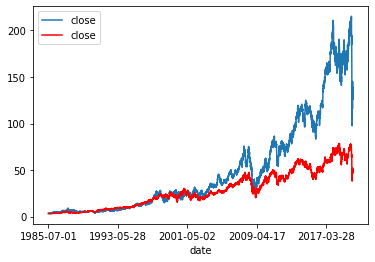

In [439]:

ax = first_stock_df.plot(y='close')
second_stock_df.plot(y='close', color='red', ax=ax)

In [444]:
correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8770 entries, 0 to 8769
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8770 non-null   object 
 1   correlation  8769 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.2+ KB


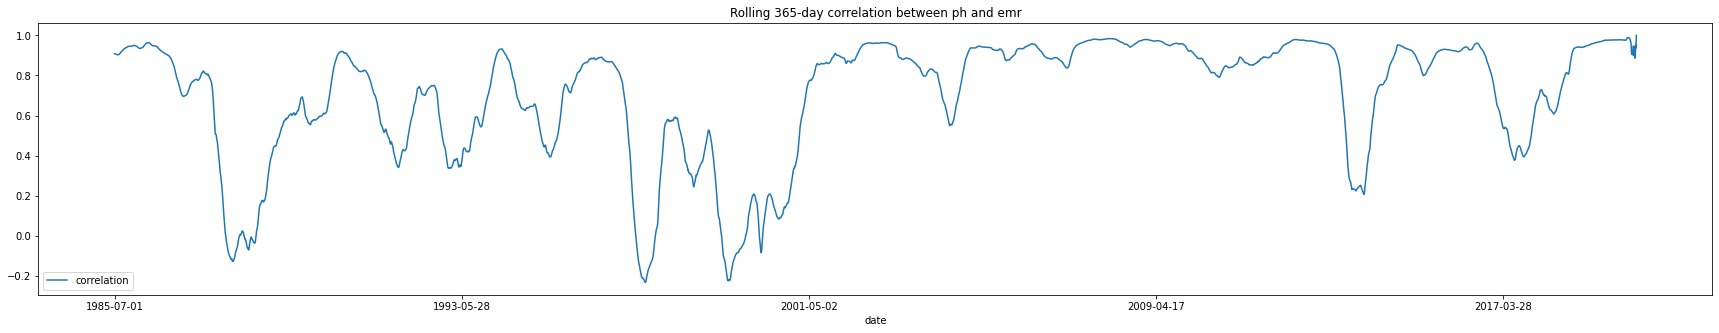

In [445]:
correlation_df.set_index('date').plot(figsize=(30,5), title='Rolling 365-day correlation between ph and emr')

## Build a function to create correlation features for all pairs of stocks

In [1151]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 6, 7, 8, 10], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{first_stock_name}"].date), :]

            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')
            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [1152]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=55):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = datetime.datetime(1970,1,1)

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [1153]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]

    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
    
    return final_stock_df

In [1154]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [1155]:
# 100 minutes for 20 stocks (20*20 = 400 pairs each pair takes .25 minutes)
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':



Finished 0.0 pct of stocks

two stocks matche!
eqix
eqix

Finished 0.047619047619047616 pct of stocks

two stocks matche!
rost
eqix
two stocks matche!
rost
rost

Finished 0.09523809523809523 pct of stocks

two stocks matche!
so
eqix
two stocks matche!
so
rost
two stocks matche!
so
so

Finished 0.14285714285714285 pct of stocks

two stocks matche!
emr
eqix
two stocks matche!
emr
rost
two stocks matche!
emr
so
two stocks matche!
emr
emr

Finished 0.19047619047619047 pct of stocks

two stocks matche!
atvi
eqix
two stocks matche!
atvi
rost
two stocks matche!
atvi
so
two stocks matche!
atvi
emr
two stocks matche!
atvi
atvi

Finished 0.23809523809523808 pct of stocks

two stocks matche!
ce
eqix
two stocks matche!
ce
rost
two stocks matche!
ce
so
two stocks matche!
ce
emr
two stocks matche!
ce
atvi
two stocks matche!
ce
ce

Finished 0.2857142857142857 pct of stocks

two stocks matche!
cern
eqix
two stocks matche!
cern
rost
two stocks matche!
cern
so
two stocks matche!
cern
emr
two stocks mat

In [1156]:
final_stock_df[~pd.isna(final_stock_df.pnr_bac_close_corr_rolling_3_days)]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,pnr_ni_close_corr_rolling_10_days,bac_ni_close_corr_rolling_3_days,bac_ni_close_corr_rolling_6_days,bac_ni_close_corr_rolling_7_days,bac_ni_close_corr_rolling_8_days,bac_ni_close_corr_rolling_10_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.674725,0.227786,0.034755,34417.241396,1.370540e+06,101044.0,4053375.0,0.815942,0.955232,0.247500,...,0.793995,0.963097,0.864588,0.897127,0.912661,0.920168,25,2,1,2005
2005-02-28,-0.674725,0.227786,0.034755,34417.241396,1.370540e+06,157510.0,3504738.0,0.815942,0.955232,0.247500,...,0.793995,0.894991,0.830166,0.809257,0.837131,0.883299,28,2,1,2005
2005-03-01,-0.674725,0.227786,0.034755,34417.241396,1.370540e+06,163370.0,6104866.0,0.815942,0.955232,0.247500,...,0.793995,0.167376,0.925655,0.823809,0.775643,0.811336,1,3,1,2005
2005-03-02,0.155460,0.249492,0.092128,9822.208577,1.749734e+06,176678.0,6833154.0,0.815942,0.955232,0.247500,...,0.793995,0.990787,0.851040,0.920439,0.812846,0.749725,2,3,1,2005
2005-03-03,0.944908,0.354056,0.210178,53985.128854,8.015813e+06,262816.0,20338472.0,0.815942,0.955232,0.247500,...,0.793995,0.082931,0.545931,0.764196,0.878973,0.746123,3,3,1,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.474303,0.417548,0.444901,0.613099,0.522359,0.649346,20,4,2,2020
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.370594,0.895677,0.754757,0.552544,0.687045,0.564808,21,4,2,2020
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.443950,-0.198245,0.422767,0.687833,0.480654,0.538137,22,4,2,2020


In [1157]:
# drop na
final_stock_df = final_stock_df.dropna()

In [1158]:
len(pairs_of_stocks)

210

In [1159]:
# last date of dtaa
last_date_of_data = '2020-04-17'

In [1160]:
final_stock_df[final_stock_df.index == last_date_of_data]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,pnr_ni_close_corr_rolling_10_days,bac_ni_close_corr_rolling_3_days,bac_ni_close_corr_rolling_6_days,bac_ni_close_corr_rolling_7_days,bac_ni_close_corr_rolling_8_days,bac_ni_close_corr_rolling_10_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,0.780499,9.816692,2.323195,87720.694094,1.496140e+06,502609.0,5081026.0,0.762826,13.356595,1.939649,...,0.79811,0.567924,0.58535,0.477854,0.544654,0.805718,17,4,2,2020


In [1162]:
pairs_of_stocks[:10]

['eqix_rost',
 'eqix_so',
 'eqix_emr',
 'eqix_atvi',
 'eqix_ce',
 'eqix_cern',
 'eqix_peg',
 'eqix_adbe',
 'eqix_rop',
 'eqix_are']

In [1163]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,pnr_ni_close_corr_rolling_10_days,bac_ni_close_corr_rolling_3_days,bac_ni_close_corr_rolling_6_days,bac_ni_close_corr_rolling_7_days,bac_ni_close_corr_rolling_8_days,bac_ni_close_corr_rolling_10_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.697482,0.282852,0.068850,20062.106769,3.307482e+06,235169.0,4918853.0,0.709943,0.385182,0.121731,...,-0.219709,0.359580,0.782241,0.685565,0.352599,0.118572,25,1,1,2006
2006-01-26,-0.712630,0.131936,0.025701,175816.922796,3.364882e+06,547429.0,5432737.0,0.801974,0.384777,0.111135,...,-0.188994,-0.103403,0.645159,0.738144,0.664665,0.200468,26,1,1,2006
2006-01-27,0.931257,0.353271,0.048220,156472.651685,5.959368e+05,373373.0,6107119.0,0.635272,0.402604,0.058964,...,-0.803803,0.025116,-0.321346,0.094006,0.272734,0.203900,27,1,1,2006
2006-01-30,0.560951,0.349257,0.057870,109960.000183,1.163736e+06,343988.0,3840744.0,0.657181,0.371951,0.060240,...,-0.903130,0.889823,-0.101178,-0.218618,0.108505,0.308339,30,1,1,2006
2006-01-31,0.999991,0.206297,0.094188,84712.417773,3.034216e+06,214178.0,9849079.0,0.167156,0.273997,0.064078,...,-0.917838,0.070913,0.166059,0.003603,-0.115543,0.343741,31,1,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.474303,0.417548,0.444901,0.613099,0.522359,0.649346,20,4,2,2020
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.370594,0.895677,0.754757,0.552544,0.687045,0.564808,21,4,2,2020
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.443950,-0.198245,0.422767,0.687833,0.480654,0.538137,22,4,2,2020


In [1164]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,pnr_ni_close_corr_rolling_10_days,bac_ni_close_corr_rolling_3_days,bac_ni_close_corr_rolling_6_days,bac_ni_close_corr_rolling_7_days,bac_ni_close_corr_rolling_8_days,bac_ni_close_corr_rolling_10_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.697482,0.282852,0.068850,20062.106769,3.307482e+06,235169.0,4918853.0,0.709943,0.385182,0.121731,...,-0.219709,0.359580,0.782241,0.685565,0.352599,0.118572,25,1,1,2006
2006-01-26,-0.712630,0.131936,0.025701,175816.922796,3.364882e+06,547429.0,5432737.0,0.801974,0.384777,0.111135,...,-0.188994,-0.103403,0.645159,0.738144,0.664665,0.200468,26,1,1,2006
2006-01-27,0.931257,0.353271,0.048220,156472.651685,5.959368e+05,373373.0,6107119.0,0.635272,0.402604,0.058964,...,-0.803803,0.025116,-0.321346,0.094006,0.272734,0.203900,27,1,1,2006
2006-01-30,0.560951,0.349257,0.057870,109960.000183,1.163736e+06,343988.0,3840744.0,0.657181,0.371951,0.060240,...,-0.903130,0.889823,-0.101178,-0.218618,0.108505,0.308339,30,1,1,2006
2006-01-31,0.999991,0.206297,0.094188,84712.417773,3.034216e+06,214178.0,9849079.0,0.167156,0.273997,0.064078,...,-0.917838,0.070913,0.166059,0.003603,-0.115543,0.343741,31,1,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.474303,0.417548,0.444901,0.613099,0.522359,0.649346,20,4,2,2020
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.370594,0.895677,0.754757,0.552544,0.687045,0.564808,21,4,2,2020
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.443950,-0.198245,0.422767,0.687833,0.480654,0.538137,22,4,2,2020


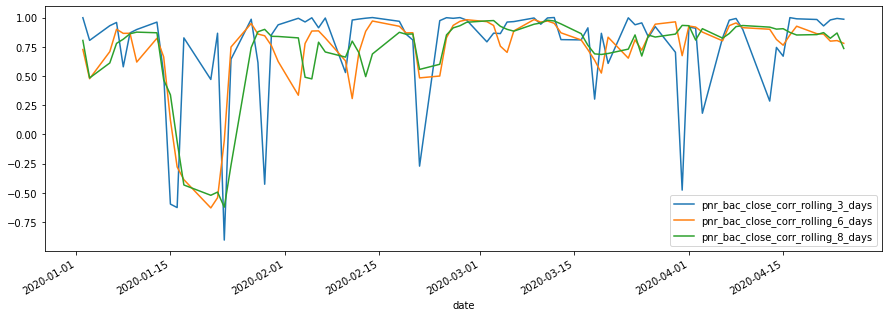

In [1165]:
final_stock_df.loc[((final_stock_df.index>'2020-01-01') & (final_stock_df.index<'2021-01-01')), :][['pnr_bac_close_corr_rolling_3_days','pnr_bac_close_corr_rolling_6_days', 
                                                'pnr_bac_close_corr_rolling_8_days']].plot(figsize=(15,5))

In [1166]:
final_stock_df.columns

Index(['eqix_rost_close_corr_rolling_3_days', 'eqix_close_std_rolling_3_days',
       'rost_close_std_rolling_3_days', 'eqix_volume_std_rolling_3_days',
       'rost_volume_std_rolling_3_days', 'eqix_volume', 'rost_volume',
       'eqix_rost_close_corr_rolling_6_days', 'eqix_close_std_rolling_6_days',
       'rost_close_std_rolling_6_days',
       ...
       'pnr_ni_close_corr_rolling_10_days', 'bac_ni_close_corr_rolling_3_days',
       'bac_ni_close_corr_rolling_6_days', 'bac_ni_close_corr_rolling_7_days',
       'bac_ni_close_corr_rolling_8_days', 'bac_ni_close_corr_rolling_10_days',
       'day', 'month', 'quarter', 'year'],
      dtype='object', length=1285)

## Train Test Split to predict correlation over the next 7 days
- rolling evey day make a predictions about what the correlation will be for the next 7 days stock price

In [1167]:
datetime.timedelta(7)

datetime.timedelta(days=7)

- Rolling Predictions

In [1168]:
# drop na
final_stock_df = final_stock_df.dropna()

In [1169]:
final_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3586 entries, 2006-01-25 to 2020-04-24
Columns: 1285 entries, eqix_rost_close_corr_rolling_3_days to year
dtypes: float64(1281), int64(4)
memory usage: 35.2 MB


In [807]:
def evaluate_predictios_on_rolling_historical_data(final_stock_df, rolling_window = 7, starting_date_index= 3500,
                                                   y_col='pnr_bac_close_corr_rolling_7_days'):
    """
    Backtesting
    
    For now, assumes the final_stock only has pairs the one start stock and all others, pnc_bac, pnc_bar ...etc
    """
    
    predicted_corr_7_days = []
    actual = []
    rmse_corr_7_days = []
    prediction_date = []

    print_idx = 100
     # otherwise, takes too long
    start = time.time()

    final_row = None
    for date_idx, date in enumerate(list(final_stock_df.index)[starting_date_index:]):
    #     print((date_id x+ starting_date_index+rolling_window+1))
    #     print(len(final_stock_df))

        if final_row:
            break
        if (date_idx + starting_date_index +rolling_window +1) == len(final_stock_df): # last row
            final_row = True
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx]

        else:
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx+1]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx+1]


        prediction_date.append(test_date)

        if date_idx % print_idx == 0:
            print(f"Train dates =  {train_dates}")
            print(F"Prediction date = {test_date}")

        train_df = final_stock_df[final_stock_df.index.isin(list(train_dates))]
        test_df = final_stock_df[final_stock_df.index == test_date]

        # TODO - search for the rolling 7-days column, don't hardcode
        X_train, y_train = train_df.loc[:, train_df.columns != f"{y_col}"],  train_df.pnr_bac_close_corr_rolling_7_days
        X_test, y_test = test_df.loc[:, test_df.columns != f"{y_col}"],  test_df.pnr_bac_close_corr_rolling_7_days

    #     gb = GradientBoostingRegressor()
        rf = RandomForestRegressor(n_jobs=-1)

        X_train = np.nan_to_num(X_train.astype(np.float32)) # converting to float 32 throws some infinity errors
        rf.fit(X_train, y_train)

        prediction = rf.predict(X_test)

        predicted_corr_7_days.append(prediction[0])
        actual.append(y_test.values[0])

        rmse_corr_7_days.append(np.sqrt(mean_squared_error(y_test, prediction)))
        if date_idx % print_idx == 0:
            print('prediction = ', prediction)
            print('actual =', y_test.values)
            print('')


    end = time.time()

    print(f"Predictions took {(end-start)/60} minutes")
    
    prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 'prediction_date':prediction_date})
    
    return prediction_df

In [810]:
evaluate_predictios_on_rolling_historical_data(final_stock_df)

Train dates =  DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15',
               '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22',
               '2019-01-23', '2019-01-24'],
              dtype='datetime64[ns]', name='date', length=3501, freq=None)
Prediction date = 2019-02-05 00:00:00
prediction =  [-0.39793788]
actual = [-0.606127]



KeyboardInterrupt: 

In [803]:
np.mean(rmse_corr_7_days) # rolling 6 + 8 day corr added

0.07047565705321027

In [786]:
np.mean(rmse_corr_7_days) # rolling 6 day corr added

0.1364248274131171

In [756]:
np.mean(rmse_corr_7_days)

0.21447151296988917

In [707]:
np.mean(rmse_corr_7_days)

0.27645221273913956

In [689]:
np.mean(rmse_corr_7_days)

0.299352551057616

In [757]:
prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 'prediction_date':prediction_date})

In [758]:
prediction_df = prediction_df.set_index('prediction_date')

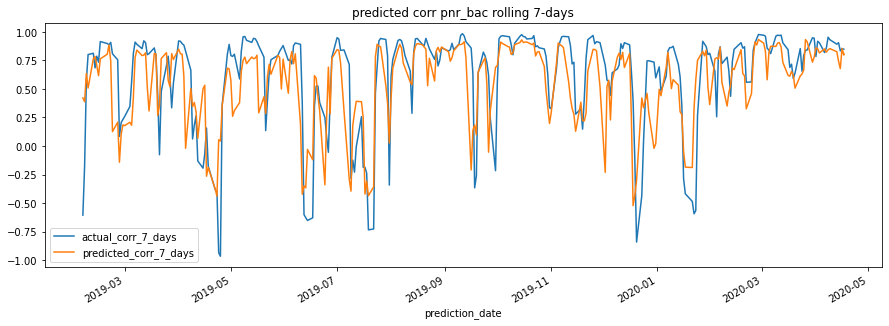

In [787]:
prediction_df.plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

In [510]:
prediction_df.index

DatetimeIndex(['2019-11-20', '2019-11-21', '2019-11-22', '2019-11-25',
               '2019-11-26', '2019-11-27', '2019-11-29', '2019-12-02',
               '2019-12-03', '2019-12-04',
               ...
               '2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-16'],
              dtype='datetime64[ns]', name='prediction_date', length=102, freq=None)

## Feature Importances
- nit: only based on last tree fit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 <a list of 35 Text major ticklabel objects>)

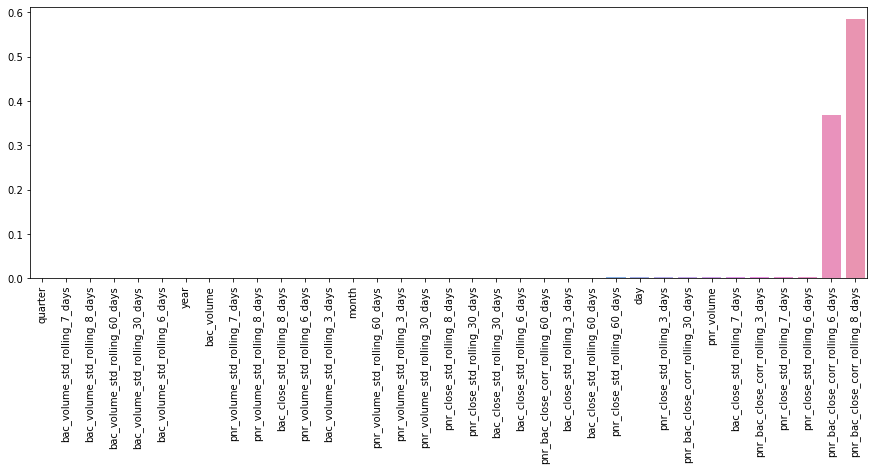

In [804]:
cols = list(final_stock_df.columns)
cols.remove('pnr_bac_close_corr_rolling_7_days')

plt.figure(figsize=(15,5))
sns.barplot(x=np.array(cols)[np.argsort(rf.feature_importances_)], y=rf.feature_importances_[np.argsort(rf.feature_importances_)])
plt.xticks(rotation=90)

# given all feature, predict next 7-days for each stock pair

In [1182]:
final_stock_df.pnr_bac_close_corr_rolling_3_days.shift(-1).fillna(method='ffill')

date
2006-01-25    0.151438
2006-01-26    0.263368
2006-01-27   -0.675648
2006-01-30   -0.245173
2006-01-31    0.848353
                ...   
2020-04-20    0.928298
2020-04-21    0.979311
2020-04-22    0.992304
2020-04-23    0.985425
2020-04-24    0.985425
Name: pnr_bac_close_corr_rolling_3_days, Length: 3586, dtype: float64

In [1013]:
np.nan_to_num(final_stock_df.astype(np.float32)

array([[1.609430e-01, 8.503500e-02, 3.168980e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [1.514380e-01, 8.503500e-02, 3.126760e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [2.633680e-01, 6.827510e-01, 1.288730e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       ...,
       [6.691380e-01, 5.577040e-01, 9.487360e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.991570e-01, 8.747000e-01, 1.176194e+00, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.890840e-01, 5.907060e-01, 9.345770e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03]], dtype=float32)

- build predicted 7 day corr for each pair

In [1170]:
# remove all 7_days_corr columns ex: so_rost_close_corr_rolling_7_days
### format: f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"
# using all data up until the last day, predict 7-day corr for each stock pair

In [1193]:
def most_recent_week_historical_prediction(final_stock_df):
    """
    Take the most recent week of data and use that to predict against 
    """

    test_date = final_stock_df.index.max()
    train_dates = final_stock_df.index[final_stock_df.index < test_date - datetime.timedelta(7)] # seven days before

    train_df = final_stock_df[final_stock_df.index.isin(train_dates)]
    test_df = final_stock_df[final_stock_df.index == test_date]


    final_stock_df = final_stock_df.dropna()

    n_days_corr_predictions = 7


    pct_change_corr = []
    actual_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    start = time.time()

    for stock_pairing in pairs_of_stocks:
        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

        # remove the current 7-day corr for this stock
        # we can't use  test_X data because we will not have access to it
        train_X, train_y = train_df.loc[:, train_df.columns != f"{pred_col_name}"],  train_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill')# shift back 7 days to get rolling corr
        
        test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"] # test has the date we want to predict against


        train_X = np.nan_to_num(train_X.astype(np.float32)) 

        # standard scaler for cols
        scaler=StandardScaler()
        scaler.fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)


        # Make an instance of the Model
        # only train on train_x

        pca = PCA(n_components=5, whiten=True)
        pca.fit(train_X)

        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)
    #     train_X = np.nan_to_num(train_X.astype(np.float32)) 

    #     print(train_X.shape)


        # standaard scaler



        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        rf.fit(train_X, train_y)


        prediction = np.array(rf.predict(test_X))[0]
        print(f"Stocks {stock_pairing}")
        print(f"Prediction = {prediction}")
        print(f"Actual = {test_y.values[0]}")

        pred_corr_pct_change, last_date = find_pct_change_pred_vs_last_corr(train_y, prediction)

        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]    

        pct_change_corr.append(pred_corr_pct_change)
        pred_dates.append(last_date)
        actual_corr.append(test_y.values[0])
        predicted_corr.append(prediction)
        last_corr_for_prediction_day.append(last_corr)

        print(f"{stock_pairing} pct change 7-day corr of close from {last_date} to {test_date} is =  {pred_corr_pct_change}")


    end = time.time()

    print(f"Predictions took {(end-start)/60} mins")
    
    pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'pct_change_for_7_daycorr': pct_change_corr,
    'actual_corr': actual_corr,
    'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day}).to_csv(
    '../data/predictions/test_predictions_2020_04_17.csv', index=False)
    


In [1194]:
most_recent_week_historical_prediction(final_stock_df)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


ValueError: Number of labels=3586 does not match number of samples=3580

most_recent_week_historical_prediction

# Final Predictions

In [ ]:
# train on all data
# predict for the upcoming week
most_recent_date = final_stock_df.index.max()
prediction_end = most_recent_date + datetime.timedelta(7)
                                                       
                                                       
# train_dates = final_stock_df.index[final_stock_df.index < test_date - datetime.timedelta(7)] # seven days before

# train_df = final_stock_df[final_stock_df.index.isin(train_dates)]
test_df = final_stock_df[final_stock_df.index == most_recent_date]

final_stock_df = final_stock_df.dropna()

n_days_corr_predictions = 7


pct_change_corr = []
predicted_corr = []
last_corr_for_prediction_day = []
pred_dates = []
start = time.time()

for stock_pairing in pairs_of_stocks:
    pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

    # remove the current 7-day corr for this stock
    # for 7 take rolling 7 days corr to the present day to predict off of
    train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                       # get corr from 7 days in the future
                                                       
    test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"]

    train_X = np.nan_to_num(train_X.astype(np.float32)) 

    # standard scaler for cols
    scaler=StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)


    # Make an instance of the Model
    # only train on train_x

    pca = PCA(n_components=5, whiten=True)
    pca.fit(train_X)

    train_X = pca.transform(train_X)
    test_X = pca.transform(test_X)

    # standaard scaler

    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
    rf.fit(train_X, train_y)


    prediction = np.array(rf.predict(test_X))[0]
    print(f"Stocks {stock_pairing}")
    print(f"Prediction = {prediction}")

    pred_corr_pct_change, last_date = find_pct_change_pred_vs_last_corr(train_y, prediction)

    last_corr_date = train_y.index.max()
    last_corr = train_y[train_y.index.max()]  
    print(f"Last corr = {last_corr})

    pct_change_corr.append(pred_corr_pct_change)
    pred_dates.append(most_recent_date)
    predicted_corr.append(prediction)
    last_corr_for_prediction_day.append(last_corr)

    print(f"{stock_pairing} pct change 7-day corr of close from {most_recent_date} to {prediction_end} is =  {pred_corr_pct_change}")


end = time.time()

print(f"Predictions took {(end-start)/60} mins")

pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'pct_change_for_7_day_corr': pct_change_corr,
'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day}).to_csv(
f'../data/predictions/test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_rost
Prediction = 0.4904762900000012
eqix_rost pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.052783483453324065


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_so
Prediction = 0.733176166361472
eqix_so pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.038210259474603325


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_emr
Prediction = 0.1659966600000001
eqix_emr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.37602403945786955


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_atvi
Prediction = 0.32267243000000007
eqix_atvi pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.03628953208112917


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ce
Prediction = 0.469236265
eqix_ce pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.08519529726905495


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_cern
Prediction = 0.3486951899999996
eqix_cern pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.052273993354919224


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_peg
Prediction = 0.6321054790476177
eqix_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.04887485302043415


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_adbe
Prediction = 0.34310693500000033
eqix_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.07040286703687637


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_rop
Prediction = 0.19616649785714255
eqix_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.4305356882412239


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_are
Prediction = 0.5941640399999989
eqix_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.032617605961805296


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_pg
Prediction = 0.46575068583333395
eqix_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.044533620605355595


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_pvh
Prediction = 0.5548192649999986
eqix_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.06984587103361461


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_lb
Prediction = 0.12162476500000013
eqix_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  2.8199932472753586


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_vno
Prediction = 0.6034189300000008
eqix_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.05862293992474088


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ual
Prediction = 0.06448574500000015
eqix_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -3.2205070417685393


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_efx
Prediction = 0.20207063658333316
eqix_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.14863114307585223


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ph
Prediction = 0.4323118199999994
eqix_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.05752458438927821


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_pnr
Prediction = 0.4227229000000003
eqix_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.03374751706907797


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_bac
Prediction = 0.4247395647500001
eqix_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.0012766791686902312


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ni
Prediction = 0.8941638652222257
eqix_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.0792124845562332


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_so
Prediction = 0.21990010499999954
rost_so pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.03737719186515309


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_emr
Prediction = -0.23724889750000064
rost_emr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.41305389662278513


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_atvi
Prediction = 0.4583372699999997
rost_atvi pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.1402511508030303


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ce
Prediction = 0.1948732000000006
rost_ce pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.009904540790417915


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_cern
Prediction = 0.011006559999999886
rost_cern pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -1.0977674344238257


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_peg
Prediction = 0.8518622250000005
rost_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.13897474422807465


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_adbe
Prediction = 0.6891971224999998
rost_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.06981150175052198


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_rop
Prediction = 0.5672406608750014
rost_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.015155843304605954


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_are
Prediction = 0.8032846697500001
rost_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.14602781097013207


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_pg
Prediction = 0.8257134524999973
rost_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.08686279112202544


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_pvh
Prediction = 0.8545875191666663
rost_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.052152852104774605


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_lb
Prediction = 0.6600268449999994
rost_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.1211465574979802


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_vno
Prediction = 0.790420263025975
rost_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.15859837086298412


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ual
Prediction = 0.6563855932797601
rost_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.045315641401165174


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_efx
Prediction = -0.30160936499999996
rost_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.40479158485107425


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ph
Prediction = 0.4430279300000005
rost_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.025740533455895


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_pnr
Prediction = 0.5262136550000007
rost_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.21975840865686758


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_bac
Prediction = 0.7000987174999991
rost_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.06753837204501412


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ni
Prediction = 0.550845014999999
rost_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.11876218442090059


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_emr
Prediction = 0.644107554999999
so_emr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.0744530557347759


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_atvi
Prediction = -0.0019361949999999928
so_atvi pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.9772463981009237


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ce
Prediction = 0.5631804408333345
so_ce pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.33258304683892137


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_cern
Prediction = 0.6650118799999986
so_cern pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.15410109901292535


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_peg
Prediction = 0.3301729466666666
so_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.1343342769715623


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_adbe
Prediction = 0.2485024400000002
so_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.02005377293046129


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_rop
Prediction = 0.05655679000000038
so_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  23.729685177088054


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_are
Prediction = 0.25948353666666574
so_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.14846722640476284


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_pg
Prediction = 0.15343280000000042
so_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  2.3486719483183927


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_pvh
Prediction = 0.4888235350000012
so_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.030271265709934436


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_lb
Prediction = -0.1102610250000001
so_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.661005460263974


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_vno
Prediction = 0.21748938333333345
so_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.24812418341912879


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ual
Prediction = -0.29028128333333403
so_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.3449267856390613


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_efx
Prediction = 0.49598298944444363
so_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.23975863126654484


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ph
Prediction = 0.6811356925000002
so_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.03692509095073715


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_pnr
Prediction = 0.4932221602373746
so_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.03272892673942196


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_bac
Prediction = 0.5145850299999998
so_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.046819435685659716


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ni
Prediction = 0.66379865
so_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.11399715165121471


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_atvi
Prediction = -0.4217586050000005
emr_atvi pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.330036765815495


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ce
Prediction = 0.7603664370000003
emr_ce pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.026702306755910565


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_cern
Prediction = 0.6217694373333345
emr_cern pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2757077138551478


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_peg
Prediction = -0.16651055500000012
emr_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.5303462947658788


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_adbe
Prediction = -0.03371865499999987
emr_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.741455063373641


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_rop
Prediction = 0.08401767166666668
emr_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -1.5430374724768074


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_are
Prediction = -0.2697536449999993
emr_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.381375597976399


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_pg
Prediction = -0.39718859500000003
emr_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2653824763165974


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_pvh
Prediction = 0.01661339500000004
emr_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -1.391004612958649


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_lb
Prediction = -0.3919355958531752
emr_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.38478699324382726


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_vno
Prediction = -0.29158698916666553
emr_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.42400863400068045


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ual
Prediction = -0.47188976384004744
emr_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.3876349090191209


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_efx
Prediction = 0.7917727200000012
emr_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.10612534094398451


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ph
Prediction = 0.5867001965873004
emr_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.04175764642629565


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_pnr
Prediction = 0.28334921500000115
emr_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.321813434158726


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_bac
Prediction = 0.2610585750000008
emr_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.4099232817377634


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ni
Prediction = 0.15953573999999945
emr_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  1.559698039341518


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_ce
Prediction = -0.28123215499999965
atvi_ce pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2067442860809704


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_cern
Prediction = -0.08491582499999999
atvi_cern pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.5545492815888454


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_peg
Prediction = 0.48754738000000086
atvi_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.07324655328741991


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_adbe
Prediction = 0.5857067250000009
atvi_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.025399353712573736


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_rop
Prediction = -0.05931718500000031
atvi_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.02495438287284757


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_are
Prediction = 0.5434620400000015
atvi_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.17528811542827083


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_pg
Prediction = 0.4368212125000008
atvi_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.14557125642189161


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_pvh
Prediction = 0.13358572499999977
atvi_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.20656126940004782


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_lb
Prediction = 0.12019904875000004
atvi_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.31935191398397444


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_vno
Prediction = 0.48386468000000143
atvi_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.23578070880629765


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_ual
Prediction = 0.23048484
atvi_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.17472361269254721


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_efx
Prediction = -0.4406528350000006
atvi_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.3106656691341638


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_ph
Prediction = -0.3113201362500008
atvi_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.0518389837090073


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_pnr
Prediction = 0.17588120499999993
atvi_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.27569635709226314


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_bac
Prediction = -0.05644316000000019
atvi_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2961848471245425


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks atvi_ni
Prediction = 0.46114384571428707
atvi_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.05758226576823533


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_cern
Prediction = 0.6279378199999981
ce_cern pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2507513274230714


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_peg
Prediction = 0.2376172716666675
ce_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.028539596944098133


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_adbe
Prediction = 0.3315532103781215
ce_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.028515140196253785


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_rop
Prediction = 0.2994361424999995
ce_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.273356477642404


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_are
Prediction = 0.13863538999999975
ce_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.3171382832169469


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_pg
Prediction = 0.04973675499999994
ce_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.6566217566532304


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_pvh
Prediction = 0.5107535070000012
ce_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.02821162294679369


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_lb
Prediction = -0.14027576999999977
ce_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2406032373321797


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_vno
Prediction = 0.16427665583333284
ce_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.3699082359056425


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_ual
Prediction = -0.2233633999999994
ce_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.43384078028206285


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_efx
Prediction = 0.47156907499999984
ce_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.1485602122600207


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_ph
Prediction = 0.7577104962499994
ce_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.09932221726277224


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_pnr
Prediction = 0.6394122950000013
ce_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.08445596051523596


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_bac
Prediction = 0.666860249999998
ce_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.01503271008121665


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_ni
Prediction = 0.4711204891666677
ce_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.017958858274826794


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_peg
Prediction = 0.05569212500000007
cern_peg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -1.7641410087538771


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_adbe
Prediction = 0.3742160050000008
cern_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.12237303360676877


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_rop
Prediction = -0.09543519750000012
cern_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.48462993714156044


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_are
Prediction = -0.0011285850000000409
cern_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.9916245389576172


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_pg
Prediction = -0.20800461999999936
cern_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.48639185949178776


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_pvh
Prediction = 0.17856621000000028
cern_pvh pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.3694462892946728


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_lb
Prediction = -0.46241055000000075
cern_lb pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2465030162004661


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_vno
Prediction = -0.08716199499999976
cern_vno pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.5001978577121802


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ual
Prediction = -0.3813038275000001
cern_ual pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.49506748587712757


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_efx
Prediction = 0.5715341449999991
cern_efx pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.05986694992343011


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ph
Prediction = 0.4274620833333339
cern_ph pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.2050175128634295


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_pnr
Prediction = 0.45950357499999916
cern_pnr pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.19570325969568392


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_bac
Prediction = 0.26165834500000046
cern_bac pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.020309397543382568


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ni
Prediction = 0.4041631950000012
cern_ni pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  0.14712524160794138


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_adbe
Prediction = 0.6401821650000009
peg_adbe pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.10423942883528159


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_rop
Prediction = 0.5739525850000017
peg_rop pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.04822832301885516


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_are
Prediction = 0.8003766286250013
peg_are pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.17148964525906063


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_pg
Prediction = 0.7980078349999995
peg_pg pct change 7-day corr of close from 2020-04-24 00:00:00 to 2020-05-01 00:00:00 is =  -0.1256126841893046


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
